# siim data preprocess  

## 1. review label  


In [3]:
import os
import sys
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

from util import mask2rle, rle2mask

In [4]:
# configs

data_path = '../../data/siim-pneumothorax'
train_path = os.path.join(data_path, 'train_png')

anno_filename = 'train-rle.csv'


In [5]:
# Plot some samples
import colorsys
from matplotlib import patches,  lines

def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask > 0.5,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

def plot_sample(img, target=None, result=None):
    fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12, 4))
    
    # TODO : check type
    img = img * 255.
    ax0.imshow(img.astype(np.uint8))
    
    # target
    if target is not None and len(target['boxes']) > 0:
        target_img = img.astype(np.uint32).copy()
        target_colors = random_colors(len(target['boxes']))
        
        for box, mask, color in zip(target['boxes'], target['masks'], target_colors):
            # box
            x1, y1, x2, y2 = box
            
            p = patches.Rectangle(
                (x1, y1),
                x2 - x1,
                y2 - y1,
                linewidth=2,
                alpha=0.7,
                linestyle="dashed",
                facecolor='none',
                edgecolor=color,
            )
            ax1.add_patch(p)

            # mask
            target_img = apply_mask(target_img, mask.cpu().numpy().squeeze(), color)

            ax1.imshow(target_img.astype(np.uint8))
        
    # result
    if result is not None and len(result['scores']) > 0:
        result_img = img.astype(np.uint32).copy()
        result_colors = random_colors(len(target['boxes']))
        
        for box, score, mask, color in zip(result['boxes'], result['scores'], result['masks'], result_colors):
            x1, y1, x2, y2 = box
            
            p = patches.Rectangle(
                (x1, y1),
                x2 - x1,
                y2 - y1,
                linewidth=2,
                alpha=0.7,
                linestyle="dashed",
                facecolor='none',
                edgecolor=color,
            )
            ax2.add_patch(p)

            # score for result
            ax2.text(
                x1,
                y1+8,
                '{:.3f}'.format(score),
                color='w',
                size=11,
                backgroundcolor='none'
            )

            # mask
            result_img = apply_mask(result_img, mask.cpu().numpy(), color)
        
        ax2.imshow(result_img.astype(np.uint8))

    ax1.set_title('target')
    ax2.set_title('pred')
    
    plt.show()
    

In [6]:
# read anno

anno_df = pd.read_csv(os.path.join(data_path, anno_filename), sep='\s*,\s*')

anno_df.head(5)


/home/voyager/anaconda3/envs/siim/lib/python3.7/site-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,-1
1,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,-1
2,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,175349 7 1013 12 1009 17 1005 19 1003 20 1002 ...
3,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,407576 2 1021 7 1015 10 1013 12 1011 14 1008 1...
4,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 10...


## 2. get train val lists

In [7]:
# unique ids
unique_id_list = np.array(list(set(list(anno_df['ImageId']))))

mask_df = anno_df[anno_df['EncodedPixels']!='-1']
mask_id_list = list(mask_df['ImageId'])

unique_mask_id_list = list(set(mask_id_list))

print('all uniq ids: {}, masked uniq ids: {}'.format(len(unique_id_list), len(unique_mask_id_list)))


all uniq ids: 10675, masked uniq ids: 2379


let's pick 5-fold sets  
then filter the masked samples to form positive only sets  


In [10]:
# pick val set

from sklearn.model_selection import StratifiedKFold, train_test_split

# config
FOLD = 5
TAG = 'SIIM_{}-FOLD'.format(FOLD)
            
# main
target_list = np.array([0 if mid not in unique_mask_id_list else 1 for mid in unique_id_list])
k_fold = StratifiedKFold(n_splits=FOLD, shuffle=True)

train_lists = []
val_lists = []

i = 0
for train_ids, val_ids in k_fold.split(unique_id_list, target_list):
    train_lists.append([unique_id_list[index] for index in train_ids])
    val_lists.append([unique_id_list[index] for index in val_ids])
    
    print('fold {} - train: {}, val: {}'.format(i, len(train_lists[i]), len(val_lists[i])))
    i += 1

fold 0 - train: 8539, val: 2136
fold 1 - train: 8540, val: 2135
fold 2 - train: 8540, val: 2135
fold 3 - train: 8540, val: 2135
fold 4 - train: 8541, val: 2134


100%|██████████| 11582/11582 [00:00<00:00, 13953.52it/s]


TypeError: Invalid shape (3, 800, 800) for image data

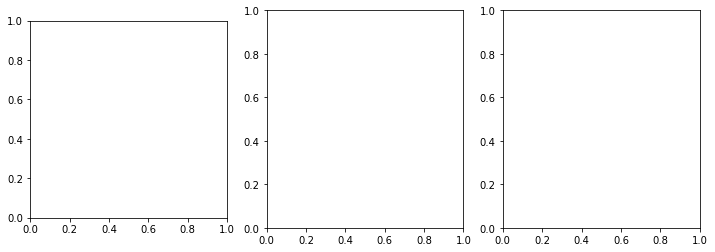

In [8]:
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from imgaug.augmentables.segmaps import SegmentationMapOnImage

from dataset import SIIM_MaskRCNN_Dataset

# actual train aug
train_aug = iaa.Sequential(
    [
        iaa.Sometimes(0.5, iaa.ContrastNormalization((0.5, 1.5))),
        iaa.Sometimes(0.5,iaa.GaussianBlur(sigma=(0.0, 0.75))),
        iaa.Fliplr(0.5),
        iaa.Sometimes(
            0.5,
            iaa.CropAndPad(
                percent=(-0.05, 0.1),
                pad_mode=ia.ALL,
                pad_cval=0
            )
        ),
        iaa.Sometimes(
            0.5,
            iaa.Affine(
                scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
                translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
                rotate=(-15, 15),
                shear=(-10, 10),
                order=[1],
                cval=0,
                mode=ia.ALL
            )
        ),
        iaa.Sometimes(
            0.5,
            iaa.OneOf([
                iaa.AdditiveGaussianNoise(scale=(0, 0.025*1)),
                iaa.Dropout(p=(0, 0.05)),
            ])
        ),
    ]
)

dataset_train = SIIM_MaskRCNN_Dataset(
    os.path.join(data_path, "train-rle.csv"),
    os.path.join(data_path, 'train_png'),
    os.path.join(data_path, 'SIIM_5-FOLD_POS'),
    fold=0,
    phrase='train',
    height=800,
    width=800,
    aug=train_aug
)

# let's load and watch some sample
sample_count = 5

for i, data in enumerate(dataset_train):
    img, target = data
    target['masks'] = target['masks'] * 255
    
    plot_sample(img.cpu().numpy(), target=target)
        
    if i == sample_count - 1:
        break


## UNET dataset

for UNET, we need to merge multiple mask instances into one  
so each id has only one mask - that forms a sample  


(1024, 1024)


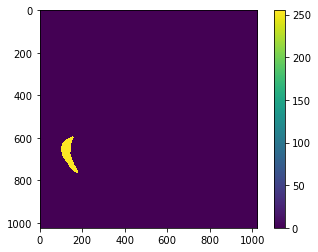

(1024, 1024)


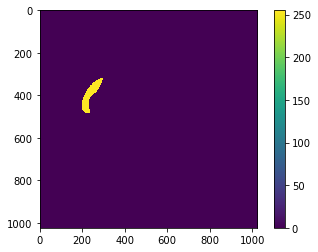

(1024, 1024)


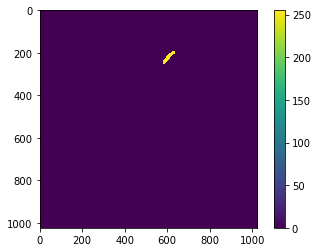

(1024, 1024)


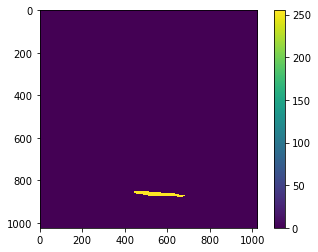

(1024, 1024)


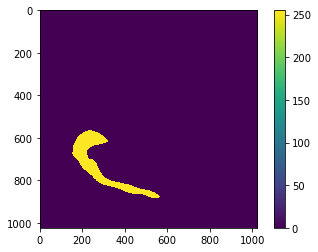

In [4]:
# try to convert and draw mask

mask_df = anno_df[anno_df['EncodedPixels']!='-1']
img_list = os.listdir(train_path)

for i in range(5):
    index = random.randint(0, len(mask_df)-1)

    imageId = mask_df.iloc[index]['ImageId']
    img_filename = os.path.join(train_path, '{}.png'.format(imageId))
    img = Image.open(img_filename)
    w, h = img.size

    mask = rle2mask(mask_df.iloc[index]['EncodedPixels'], w, h)
    print(mask.shape)

    plt.imshow(mask)
    plt.colorbar()
    plt.show()

In [5]:
# unique ids
unique_id_list = np.array(list(set(list(anno_df['ImageId']))))

mask_id_list = list(mask_df['ImageId'])
unique_mask_id_list = list(set(mask_id_list))

print('with dup: {}, without dup: {}'.format(len(mask_id_list), len(unique_mask_id_list)))

with dup: 3286, without dup: 2379


In [6]:
# merge multi mask in one sample

# simple check
for mid in mask_id_list:
    if mid not in unique_mask_id_list:
        print('Oops! {}'.format(mid))

mask_path = os.path.join(data_path, 'mask_png')
if not os.path.exists(mask_path):
    os.mkdir(mask_path)

def write_mask(umid):
    # get pic width and height
    img_filename = os.path.join(train_path, '{}.png'.format(umid))
    img = Image.open(img_filename)
    w, h = img.size

    rles = list(mask_df[mask_df['ImageId']==umid]['EncodedPixels'])

    img_mask = np.zeros(w * h)
    img_mask = img_mask.reshape(w, h)

    for rle in rles:
        mask = rle2mask(rle, w, h)
        img_mask = np.maximum(img_mask, mask)

    mask_img = Image.fromarray(img_mask.T).convert('RGB')
    mask_img.save(os.path.join(data_path, 'mask_png/{}.png'.format(umid)), 'PNG')
    
def write_empty_mask(uid):
    # get pic width and height
    img_filename = os.path.join(train_path, '{}.png'.format(uid))
    img = Image.open(img_filename)
    w, h = img.size

    img_mask = np.zeros(w * h)
    img_mask = img_mask.reshape(w, h)

    mask_img = Image.fromarray(img_mask).convert('RGB')
    mask_img.save(os.path.join(data_path, 'mask_png/{}.png'.format(uid)), 'PNG')
    
# ok, merge
'''
with tqdm(total=len(unique_mask_id_list), file=sys.stdout) as pbar:
    for i, umid in enumerate(unique_mask_id_list):
        # get pic width and height
        img_filename = os.path.join(train_path, '{}.png'.format(umid))
        img = Image.open(img_filename)
        w, h = img.size

        rles = list(mask_df[mask_df['ImageId']==umid]['EncodedPixels'])

        img_mask = np.zeros(w * h)
        img_mask = img_mask.reshape(w, h)

        for rle in rles:
            mask = rle2mask(rle, w, h)
            img_mask = np.maximum(img_mask, mask)

        mask_img = Image.fromarray(img_mask.T).convert('RGB')
        mask_img.save(os.path.join(data_path, 'mask_png/{}.png'.format(umid)), 'PNG')
        
        pbar.update(1)
'''

import multiprocessing as mp

pool = mp.Pool(processes=8)

pool.map(write_mask, unique_mask_id_list)

empty_mask_id_list = []

for uid in unique_id_list:
    if uid not in unique_mask_id_list:
        empty_mask_id_list.append(uid)
        
pool.map(write_empty_mask, empty_mask_id_list)

print('done')

done


In [7]:
# check train and mask

train_file_list = os.listdir(train_path)
mask_file_list = os.listdir(os.path.join(data_path, 'mask_png'))

for train_file in train_file_list:
    if train_file not in mask_file_list:
        print('extra train_file: {}'.format(train_file))
        
for mask_file in mask_file_list:
    if mask_file not in train_file_list:
        print('extra mask_file: {}'.format(mask_file))
        

extra train_file: 1.2.276.0.7230010.3.1.4.8323329.4843.1517875185.73985.png
extra train_file: 1.2.276.0.7230010.3.1.4.8323329.31801.1517875156.929061.png
extra train_file: 1.2.276.0.7230010.3.1.4.8323329.32688.1517875161.809571.png
extra train_file: 1.2.276.0.7230010.3.1.4.8323329.11215.1517875231.757436.png
extra train_file: 1.2.276.0.7230010.3.1.4.8323329.11557.1517875233.601090.png
extra train_file: 1.2.276.0.7230010.3.1.4.8323329.4373.1517875182.554858.png
extra train_file: 1.2.276.0.7230010.3.1.4.8323329.32302.1517875159.778024.png
extra train_file: 1.2.276.0.7230010.3.1.4.8323329.3714.1517875179.128897.png
extra train_file: 1.2.276.0.7230010.3.1.4.8323329.2083.1517875171.71387.png
extra train_file: 1.2.276.0.7230010.3.1.4.8323329.10599.1517875224.488727.png
extra train_file: 1.2.276.0.7230010.3.1.4.8323329.5543.1517875188.726955.png
extra train_file: 1.2.276.0.7230010.3.1.4.8323329.5087.1517875186.354925.png
extra train_file: 1.2.276.0.7230010.3.1.4.8323329.4134.1517875181.277174

In [11]:
# pick val set

from sklearn.model_selection import StratifiedKFold, train_test_split

# config
FOLD = 5
TAG = 'SIIM_{}-FOLD'.format(FOLD)

# helper
def write_csv(tag, path, phase, index, samples, row_pattern='{}\n'):
    sub_dir = os.path.join(path, '{}'.format(tag))
    
    if not os.path.isdir(sub_dir):
        os.mkdir(sub_dir)
        
    filename = os.path.join(sub_dir, '{}-{}.csv'.format(phase, index))
    print('Exporting to {}...'.format(filename))
    
    with open(filename, 'w') as file:
        file.write('ImageId\n')
        
        for sample in samples:
            if phase == 'val':
                file.write(row_pattern.format(sample))
            else:
                file.write(row_pattern.format(sample))
            
# main
target_list = np.array([0 if mid not in unique_mask_id_list else 1 for mid in unique_id_list])

k_fold = StratifiedKFold(n_splits=FOLD, shuffle=True)

i = 0

for train_ids, val_ids in k_fold.split(unique_id_list, target_list):
    write_csv(TAG, data_path, 'train', i, [unique_id_list[index] for index in train_ids], row_pattern='train_png_256/{}.png\n')
    write_csv(TAG, data_path, 'val', i, [unique_id_list[index] for index in val_ids], row_pattern='train_png_256/{}.png\n')
    
    i += 1
    
write_csv(TAG, data_path, 'all', 0, unique_id_list, row_pattern='train_png_256/{}.png\n')




Exporting to ../../data/siim-pneumothorax/SIIM_5-FOLD/train-0.csv...
Exporting to ../../data/siim-pneumothorax/SIIM_5-FOLD/val-0.csv...
Exporting to ../../data/siim-pneumothorax/SIIM_5-FOLD/train-1.csv...
Exporting to ../../data/siim-pneumothorax/SIIM_5-FOLD/val-1.csv...
Exporting to ../../data/siim-pneumothorax/SIIM_5-FOLD/train-2.csv...
Exporting to ../../data/siim-pneumothorax/SIIM_5-FOLD/val-2.csv...
Exporting to ../../data/siim-pneumothorax/SIIM_5-FOLD/train-3.csv...
Exporting to ../../data/siim-pneumothorax/SIIM_5-FOLD/val-3.csv...
Exporting to ../../data/siim-pneumothorax/SIIM_5-FOLD/train-4.csv...
Exporting to ../../data/siim-pneumothorax/SIIM_5-FOLD/val-4.csv...
Exporting to ../../data/siim-pneumothorax/SIIM_5-FOLD/all-0.csv...


In [12]:
# write only positive version
TAG = 'SIIM_{}-FOLD'.format(FOLD)
row_pattern ='{}\n'
# row_pattern = 'train_png_256/{}.png\n'

target_list = np.array([0 if mid not in unique_mask_id_list else 1 for mid in unique_mask_id_list]) # yeah, all 1s

i = 0

for train_ids, val_ids in k_fold.split(unique_mask_id_list, target_list):
    write_csv('{}_POS'.format(TAG), data_path, 'train', i, [unique_mask_id_list[index] for index in train_ids], row_pattern=row_pattern)
    write_csv('{}_POS'.format(TAG), data_path, 'val', i, [unique_mask_id_list[index] for index in val_ids], row_pattern=row_pattern)
    
    i += 1
    
write_csv('{}_POS'.format(TAG), data_path, 'all', 0, unique_mask_id_list, row_pattern=row_pattern)


Exporting to ../../data/siim-pneumothorax/SIIM_5-FOLD_POS/train-0.csv...
Exporting to ../../data/siim-pneumothorax/SIIM_5-FOLD_POS/val-0.csv...
Exporting to ../../data/siim-pneumothorax/SIIM_5-FOLD_POS/train-1.csv...
Exporting to ../../data/siim-pneumothorax/SIIM_5-FOLD_POS/val-1.csv...
Exporting to ../../data/siim-pneumothorax/SIIM_5-FOLD_POS/train-2.csv...
Exporting to ../../data/siim-pneumothorax/SIIM_5-FOLD_POS/val-2.csv...
Exporting to ../../data/siim-pneumothorax/SIIM_5-FOLD_POS/train-3.csv...
Exporting to ../../data/siim-pneumothorax/SIIM_5-FOLD_POS/val-3.csv...
Exporting to ../../data/siim-pneumothorax/SIIM_5-FOLD_POS/train-4.csv...
Exporting to ../../data/siim-pneumothorax/SIIM_5-FOLD_POS/val-4.csv...
Exporting to ../../data/siim-pneumothorax/SIIM_5-FOLD_POS/all-0.csv...


In [14]:
# resize image

size = 256, 256
output_path = 'resize'

def resize_image(input_file):
    sub_path, filename = os.path.split(input_file)
    sub_path = '{}_{}'.format(sub_path, size[0])
    
    output_file = os.path.join(data_path, '{}/{}'.format(sub_path, filename))
    
    im = Image.open(input_file)
    im.thumbnail(size, Image.ANTIALIAS)
    im.save(output_file, "PNG")
    
import multiprocessing as mp

pool = mp.Pool(processes=8)

# resize train pic
input_files = os.listdir(train_path)
input_files = [os.path.join(train_path, input_file) for input_file in input_files]

new_input_path = '{}_{}'.format(train_path, size[0])
if not os.path.exists(new_input_path):
    os.mkdir(new_input_path)

pool.map(resize_image, input_files)

# resize mask pic
mask_path = os.path.join(data_path, 'mask_png')

new_mask_path = '{}_{}'.format(mask_path, size[0])
if not os.path.exists(new_mask_path):
    os.mkdir(new_mask_path)

mask_files = os.listdir(mask_path)
mask_files = [os.path.join(mask_path, mask_file) for mask_file in mask_files]
    
pool.map(resize_image, mask_files)

print('done')

done


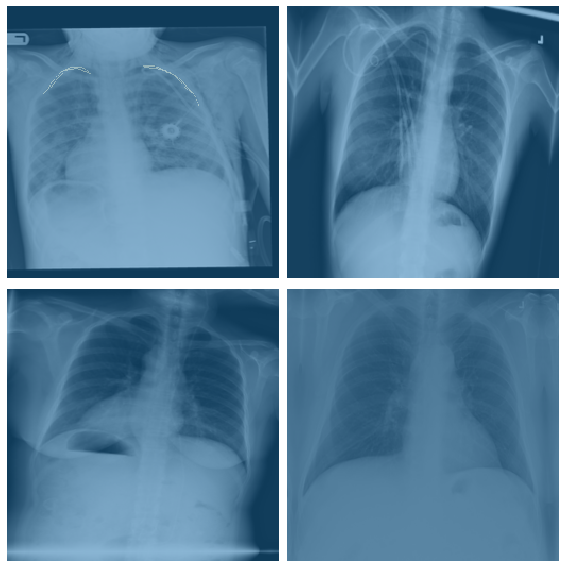

In [17]:
# let's try to use fastai to load them

import fastai
from fastai.vision import *

path = Path(data_path)

# Setting div=True in open_mask
class SegmentationLabelList(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)
    
class SegmentationItemList(SegmentationItemList):
    _label_cls = SegmentationLabelList
    
# Setting transformations on masks to False on test set
def transform(self, tfms:Optional[Tuple[TfmList,TfmList]]=(None,None), **kwargs):
    if not tfms: tfms=(None,None)
    assert is_listy(tfms) and len(tfms) == 2
    self.train.transform(tfms[0], **kwargs)
    self.valid.transform(tfms[1], **kwargs)
    kwargs['tfm_y'] = False # Test data has no labels
    if self.test: self.test.transform(tfms[1], **kwargs)
    return self
fastai.data_block.ItemLists.transform = transform

# Create databunch
data = (SegmentationItemList.from_csv(path=path, csv_name='SIIM_5-FOLD/all-0.csv')
        .split_by_fname_file('SIIM_5-FOLD/val-0.csv')
        .label_from_func(lambda x : str(x).replace('train_png', 'mask_png'), classes=[0, 1])
        .add_test((path/'test_png').ls(), label=None)
        .transform(get_transforms(), size=256, tfm_y=True)
        .databunch(path=Path('.'), bs=4)
        .normalize(imagenet_stats))

data.show_batch()

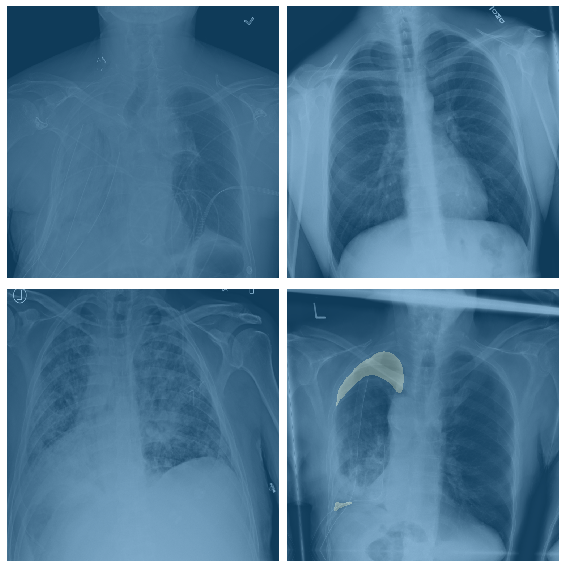

In [18]:
data.show_batch()

,1.2.276.0.7230010.3.1.4.8323329.5407.1517875187.957019.png
0,1.2.276.0.7230010.3.1.4.8323329.10218.15178752...
1,1.2.276.0.7230010.3.1.4.8323329.12190.15178752...
2,1.2.276.0.7230010.3.1.4.8323329.31825.15178751...
3,1.2.276.0.7230010.3.1.4.8323329.10062.15178752...
4,1.2.276.0.7230010.3.1.4.8323329.12713.15178752...
5,1.2.276.0.7230010.3.1.4.8323329.14446.15178752...
6,1.2.276.0.7230010.3.1.4.8323329.11139.15178752...
7,1.2.276.0.7230010.3.1.4.8323329.471.1517875163...
8,1.2.276.0.7230010.3.1.4.8323329.2872.151787517...
9,1.2.276.0.7230010.3.1.4.8323329.310.1517875162...


In [1]:
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from imgaug.augmentables.segmaps import SegmentationMapOnImage

from dataset import SIIM_MaskRCNN_Dataset

# actual train aug
train_aug = iaa.Sequential(
    [
        iaa.Sometimes(0.5, iaa.ContrastNormalization((0.5, 1.5))),
        iaa.Sometimes(0.5,iaa.GaussianBlur(sigma=(0.0, 0.75))),
        iaa.Fliplr(0.5),
        iaa.Sometimes(
            0.5,
            iaa.CropAndPad(
                percent=(-0.05, 0.1),
                pad_mode=ia.ALL,
                pad_cval=0
            )
        ),
        iaa.Sometimes(
            0.5,
            iaa.Affine(
                scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
                translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
                rotate=(-15, 15),
                shear=(-10, 10),
                order=[1],
                cval=0,
                mode=ia.ALL
            )
        ),
        iaa.Sometimes(
            0.5,
            iaa.OneOf([
                iaa.AdditiveGaussianNoise(scale=(0, 0.025*1)),
                iaa.Dropout(p=(0, 0.05)),
            ])
        ),
    ]
)

dataset_train = SIIM_MaskRCNN_Dataset(
    os.path.join(data_path, "train-rle.csv"),
    os.path.join(data_path, 'train_png'),
    os.path.join(data_path, 'SIIM_5-FOLD_POS'),
    fold=0,
    phrase='train',
    height=800,
    width=800,
    aug=train_aug
)

# let's load and watch some sample
sample_count = 5

with tqdm(total=len(dataset_train), file=sys.stdout) as pbar:
    for i, data in enumerate(dataset_train):
        img, target = data
        target['masks'] = target['masks'] * 255

        plot_sample(img.cpu().numpy().transpose((1, 2, 0)), target=target)

        if i == sample_count - 1:
            break
        
        pbar.update(1)

NameError: name 'os' is not defined